In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Whole DATA

## Get data from URL -> make timeseries

In [71]:

def repair_timestamp(data):
    data["timestamp"] = data.apply(lambda row: row["timestamp"].strip().replace(" ",""), axis=1)
    data["timestamp"] = data.apply(lambda row: datetime.strptime(row["timestamp"],"%Y-%m-%d%H:%M:%S"), axis=1)
    return data

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

def to_timeseries(series):
    series.to_csv("series_rad.csv",index=False)
    series = pd.read_csv("series_rad.csv",header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
    series.index = series.index.to_period('T')
    return series

def get_weather_data(start_year, start_month, start_day, end_year, end_month, end_day):
    url = f'https://meteo.physic.ut.ee/et/archive.php?do=data&begin%5Byear%5D={start_year}&begin%5Bmon%5D={start_month}&begin%5Bmday%5D={start_day}&end%5Byear%5D={end_year}&end%5Bmon%5D={end_month}&end%5Bmday%5D={end_day}&14=1&ok=+Esita+p%C3%A4ring+'
    d = pd.read_csv(url, sep=", ")
    d.columns = ['timestamp', 'radiation_flux']
    d = repair_timestamp(d)
    d = to_timeseries(d)
    return d

/Users/heidi/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


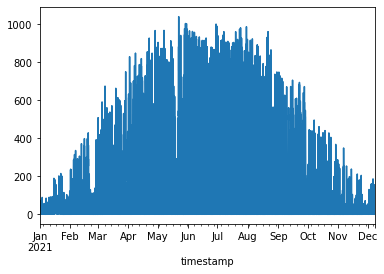

In [75]:
data = get_weather_data(2021,1,1,2021,12,8)
data.plot()
plt.show()

# ARIMA

## About

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

## Autocorrelation

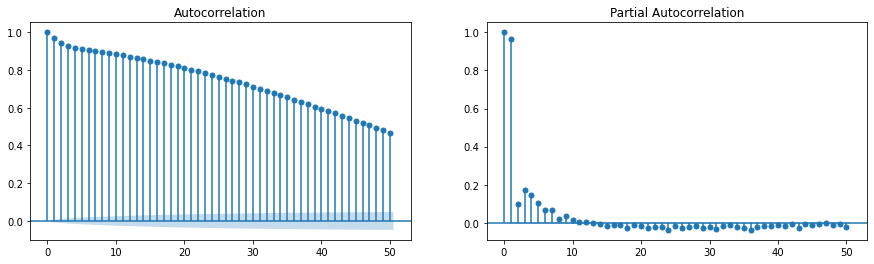

In [76]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data,lags=50,ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data,lags=50,ax=axes[1])


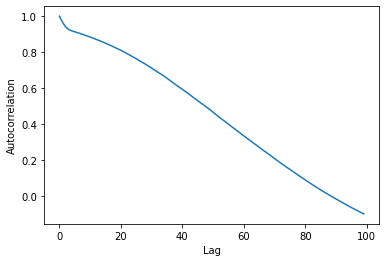

In [77]:
AC = []
for l in range(100): AC.append(data.autocorr(lag=l))
plt.plot(range(100),AC)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

## Train and predict

## Evaluate an ARIMA model using a walk-forward validation

values X:  (97712,) <class 'numpy.ndarray'>
train:  (97424,) <class 'numpy.ndarray'>
test:  (288,) <class 'numpy.ndarray'>
history:  97424 <class 'list'>


/Users/heidi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                97424
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -518234.469
Date:                Thu, 09 Dec 2021   AIC                        1036474.939
Time:                        23:53:11   BIC                        1036503.399
Sample:                             0   HQIC                       1036483.586
                              - 97424                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5624      0.002    270.777      0.000       0.558       0.566
ma.L1         -0.8059      0.002   -444.282      0.000      -0.809      -0.802
sigma2      2443.0754      2.999    814.728      0.0

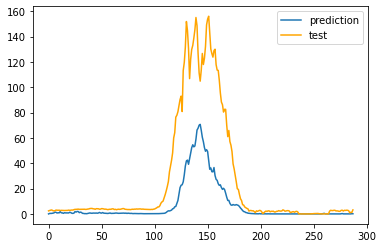

In [82]:
# split into train and test sets
X = data.values
size = int(len(X)-288) # test for last 288 intervals (24h) as we want to predict the same period
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# print set sizes and types
print("values X: ",X.shape,type(X))
print("train: ",train.shape,type(train))
print("test: ",test.shape,type(test))
print("history: ",len(history),type(history))
# hyperparameters
p, d, q = 1, 1, 1
# fit model
model = ARIMA(history, order=(p,d,q))
model_fit = model.fit() 
print(model_fit.summary())
# predict
output = model_fit.predict()
pred_radiation = output[:288]
# evaluate
rmse = np.sqrt(mean_squared_error(test, pred_radiation))
print('Test RMSE: %.3f' % rmse)
# plot test and predictions
plt.plot(pred_radiation,label="prediction")
plt.plot(test, color="orange",label="test")
plt.legend()
plt.show()

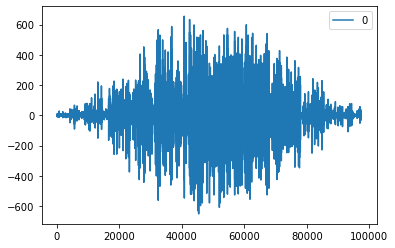

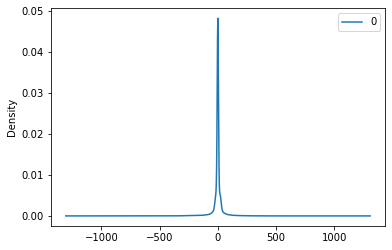

                  0
count  97424.000000
mean       0.000051
std       49.426496
min     -652.301197
25%       -1.848223
50%       -0.000033
75%        1.782339
max      654.797391


In [81]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())